# Parameter Inference

Here we infer the parameters of the systems we have observed.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tqdm_notebook
from true_params import uncert

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

We want to have a realistic prior on $d_L$; we factor out the $d_L^2$ low-redshift behavior, and then find a function that approximates $dV/dz(d_L) (1+z)^2$:

In [3]:
dLmax = Planck15.luminosity_distance(3).to(u.Gpc).value

zs = linspace(0, 3, 1000)
dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
dVddl = 4.0*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**2 / (dls/(1+zs) + (1+zs)*Planck15.hubble_distance.to(u.Gpc).value/Planck15.efunc(zs))

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


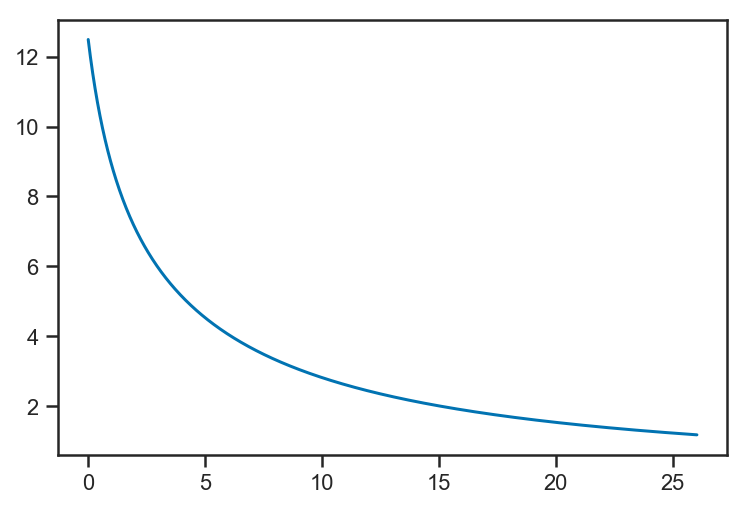

In [4]:
plot(dls, dVddl/(dls*dls))

It looks like it will be best to fit the *inverse* of $\mathrm{d}V/\mathrm{d} d_L / d_L^2$.

In [5]:
f = dls*dls/dVddl
f = f[1:]
d = dls[1:]

M = column_stack((ones_like(d), d, d*d, d*d*d))

c = np.linalg.lstsq(M, f)
c

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


(array([ 8.53711241e-02,  2.67687745e-02, -1.61983233e-05,  4.46065498e-06]),
 array([0.00157329]),
 4,
 array([1.94979033e+05, 1.52861623e+03, 5.03000860e+01, 9.09525559e+00]))

Here we compare the fit, which is 
$$
\frac{\mathrm{d} V}{\mathrm{d} d_L} \simeq \frac{d_L^2}{\sum_{i=0}^3 c_i d_L^i}
$$
and looks really good:

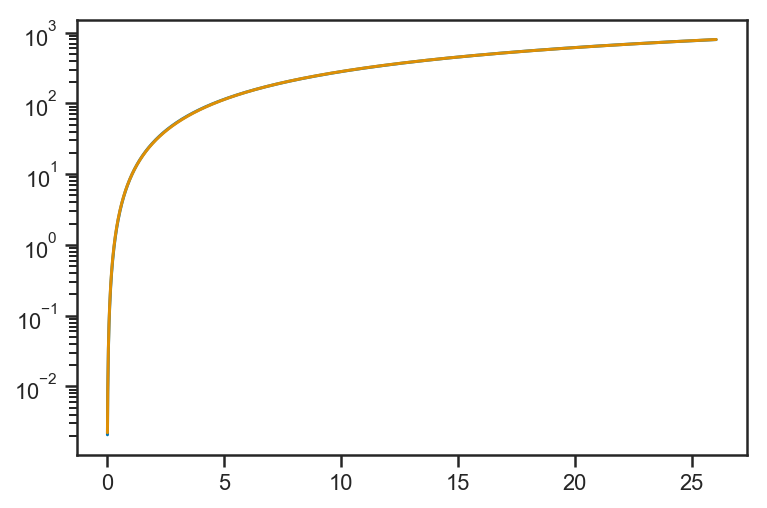

In [6]:
plot(dls[1:], dls[1:]*dls[1:]/(np.dot(M, c[0])))
plot(dls[1:], dVddl[1:])
yscale('log')

Now we compile the model and fit one of the systems just to check:

In [7]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    thetas = array(f['thetas'])
    
    mcobs = array(f['mcobs'])
    etaobs = array(f['etaobs'])
    rhoobs = array(f['rhoobs'])
    thetaobs = array(f['thetaobs'])
    
    sigma_mc = array(f['sigma_mc'])
    sigma_eta = array(f['sigma_eta'])
    sigma_rho = array(f['sigma_rho'])
    sigma_theta = array(f['sigma_t'])
    
with h5py.File('optimal_snr.h5', 'r') as f:
    ms_osnr = array(f['ms'])
    osnrs = array(f['SNR'])

In [8]:
model = pystan.StanModel('infer.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5e7d8094ffcf6f971fcddb7aca16f08 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpgi15o4dz/stanfit4anon_model_f5e7d8094ffcf6f971fcddb7aca16f08_2624033324914698871.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We try to fit the system with the largest $d_L$, just because it will be very challenging for us to get right (it's a 3-sigma upward fluctuation in the SNR, for example!).

In [9]:
ifit = argmax(dls)

data = {
    'mc_obs': mcobs[ifit],
    'eta_obs': etaobs[ifit],
    'rho_obs': rhoobs[ifit],
    'theta_obs': thetaobs[ifit],
    
    'sigma_mc': sigma_mc[ifit],
    'sigma_eta': sigma_eta[ifit],
    'sigma_theta': sigma_theta[ifit],
    
    'nm': len(ms_osnr),
    'ms': ms_osnr,
    'opt_snrs': osnrs,
    
    'dL_max': Planck15.luminosity_distance(3).to(u.Gpc).value,
}

In [11]:
fit = model.sampling(data=data, control={'adapt_delta': 0.99, 'metric': 'dense_e'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24ff1ac8>,
      dtype=object)

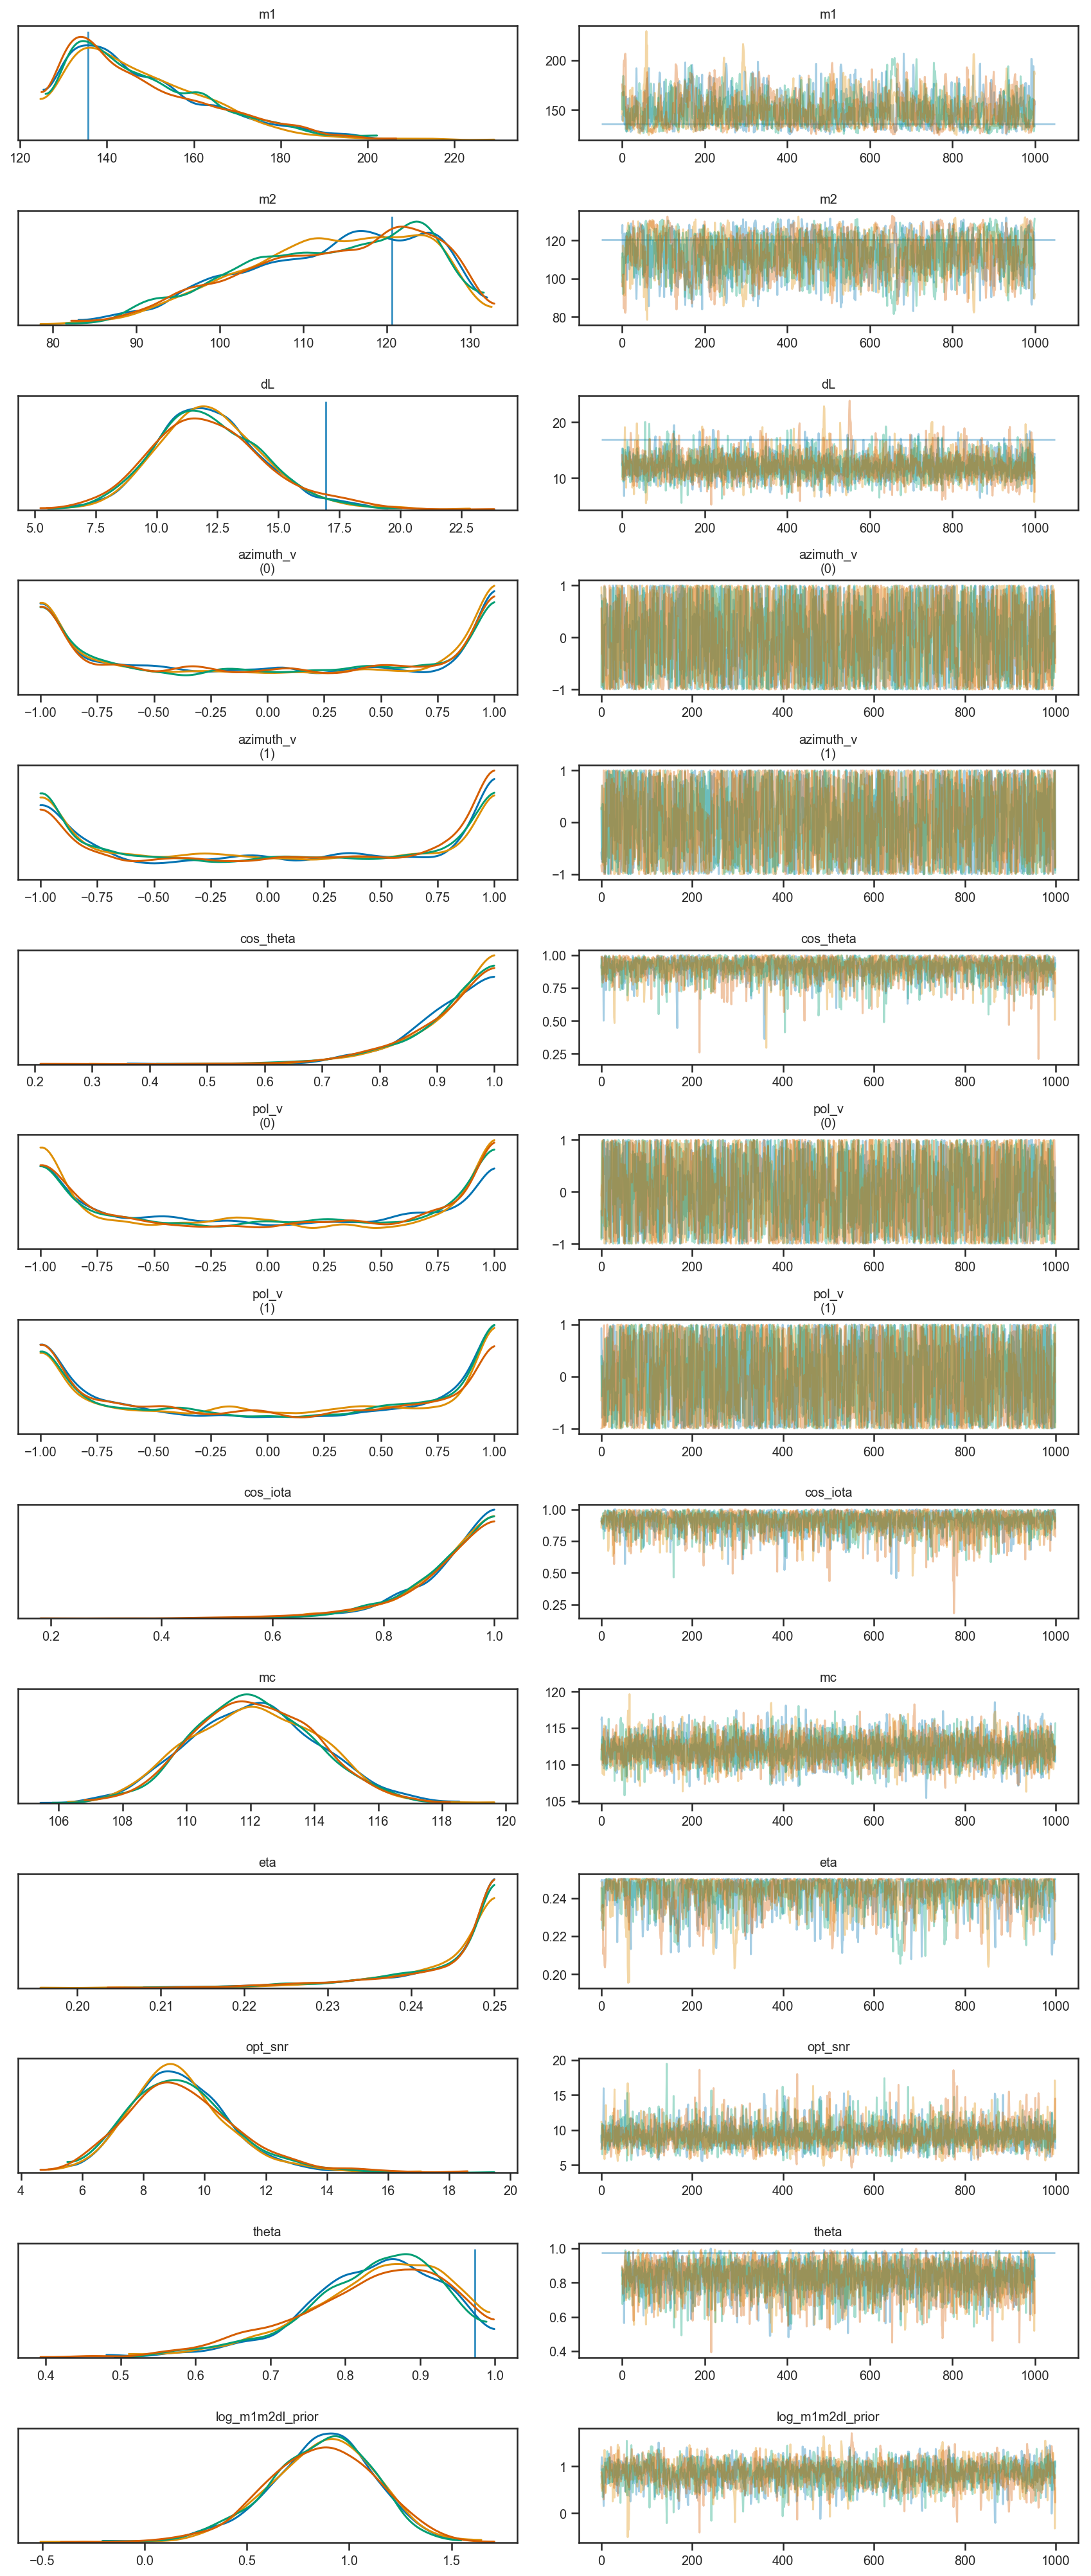

In [12]:
az.plot_trace(fit, lines=(('m1', {}, m1s[ifit]*(1+zs[ifit])),
                          ('m2', {}, m2s[ifit]*(1+zs[ifit])),
                          ('dL', {}, dls[ifit]),
                          ('theta', {}, thetas[ifit])))

The below fit takes a *long* time; it is superseded by ``infer.py``, which we can run on the cluster (12 cores FTW!).

In [16]:
with h5py.File('observations.h5', 'a') as f:
    # Delete the group for posteriors:
    try:
        del f['posteriors']
    except:
        pass 
    
    pg = f.create_group('posteriors')
    
    nobs = len(mcobs)
    nsamp = 4000
    pg.create_dataset('dl', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m1det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('m2det', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('nsamp', data=32*ones(nobs, dtype=np.int), compression='gzip', shuffle=True)
    pg.create_dataset('theta', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)
    pg.create_dataset('log_m1m2dl_prior', data=zeros((nobs, nsamp)), compression='gzip', shuffle=True)

    for i in tqdm_notebook(range(len(mcobs))):
        data = {
            'mc_obs': mcobs[i],
            'eta_obs': etaobs[i],
            'rho_obs': rhoobs[i],
            'theta_obs': thetaobs[i],

            'sigma_mc': sigma_mc[i],
            'sigma_eta': sigma_eta[i],
            'sigma_theta': sigma_theta[i],

            'nm': len(ms_osnr),
            'ms': ms_osnr,
            'opt_snrs': osnrs,

            'dL_max': 25.0
        }
        
        init = {
            'm1': m1s[i]*(1+zs[i]),
            'm2': m2s[i]*(1+zs[i]),
            'dL': dls[i]
        }
        
        fit = model.sampling(data=data, control={'max_treedepth': 15, 'adapt_delta': 0.99, 'metric': 'dense_e'}, init=4*(init,))
        chain = fit.extract(permuted=True)
        
        pg['dl'][i,:] = chain['dL']
        pg['m1det'][i,:] = chain['m1']
        pg['m2det'][i,:] = chain['m2']
        pg['theta'][i,:] = chain['theta']
        pg['log_m1m2dl_prior'][i,:] = chain['log_m1m2dl_prior']

KeyboardInterrupt: 

## Checking results

In [65]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1det_samples = array(f['posteriors']['m1det'])
    m2det_samples = array(f['posteriors']['m2det'])
    dl_samples = array(f['posteriors']['dl'])
    theta_samples = array(f['posteriors']['theta'])
    log_sample_prior = array(f['posteriors']['log_m1m2dl_prior'])

First, let's look at some z-scores for $m_1$, $m_2$, and $d_L$:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '$p\\left( z_{d_L} \\right)$')

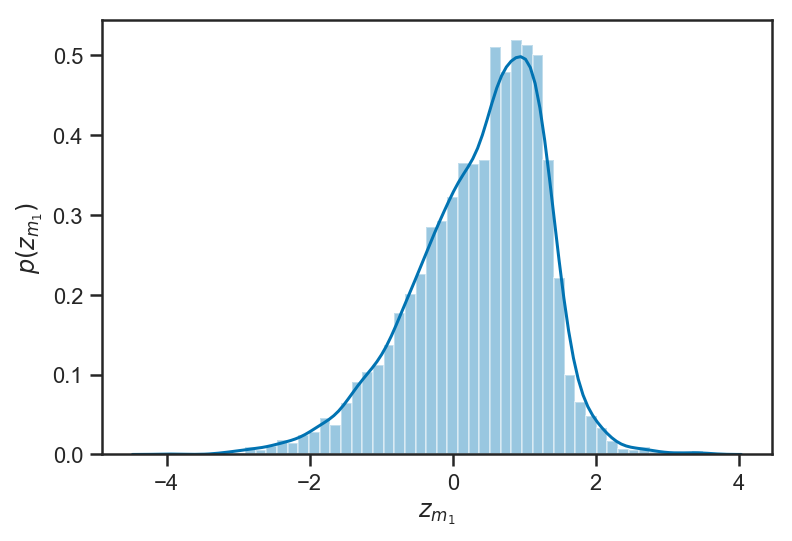

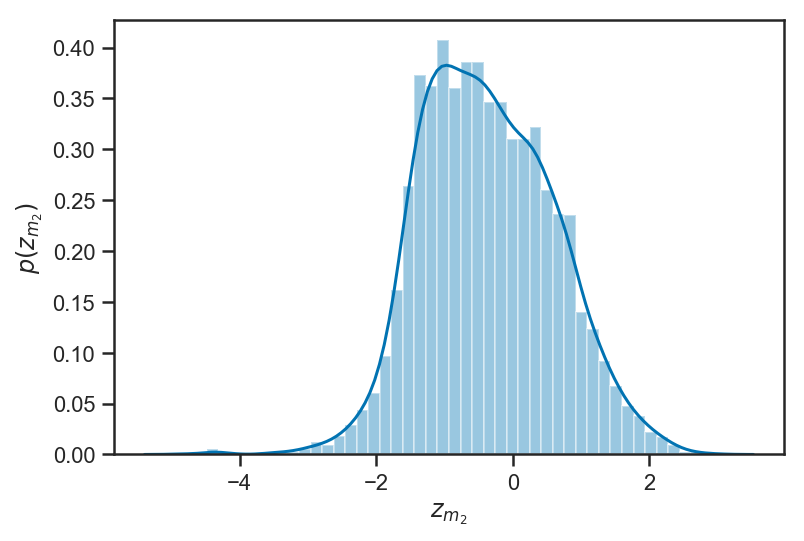

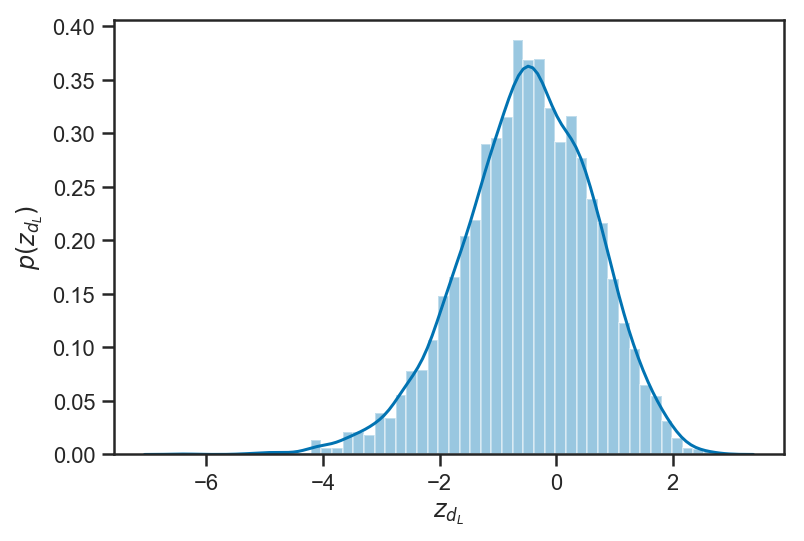

In [56]:
zscore_m1 = mean(m1det_samples - m1s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m1det_samples, axis=1)
sns.distplot(zscore_m1)
xlabel(r'$z_{m_1}$')
ylabel(r'$p\left( z_{m_1} \right)$')

figure()
zscore_m2 = mean(m2det_samples - m2s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m2det_samples, axis=1)
sns.distplot(zscore_m2)
xlabel(r'$z_{m_2}$')
ylabel(r'$p\left( z_{m_2} \right)$')

figure()
zscore_dl = mean(dl_samples - dls[:,newaxis], axis=1)/std(dl_samples, axis=1)
sns.distplot(zscore_dl)
xlabel(r'$z_{d_L}$')
ylabel(r'$p\left( z_{d_L} \right)$')

It is not surprising that we find that the $m_1$ samples are biased high (since the $m_1$ population density falls below the flat distribution at large masses), that the $m_2$ samples are more un-biased (since the population is---sort of---flat) and that the $d_L$ samples are biased low (because the true population is increasing faster than flat with $d_L$).  Reassuringly, we don't see any outliers.

Another test we can do is to check the median uncertainties in masses and distances, and compare against GW170814.  The agreement is striking (well, we tuned it to be this way).

In [57]:
print('median 90% CI in log(m1) is {:.2f}'.format(median(quantile(log(m1det_samples), 0.95, axis=1) - quantile(log(m1det_samples), 0.05, axis=1))))
print('median 90% CI in log(m2) is {:.2f}'.format(median(quantile(log(m2det_samples), 0.95, axis=1) - quantile(log(m2det_samples), 0.05, axis=1))))
print('median 90% CI in log(dL) is {:.2f}'.format(median(quantile(log(dl_samples), 0.95, axis=1) - quantile(log(dl_samples), 0.05, axis=1))))

print()

print('GW170814 had {:.2f}, {:.2f}, {:.2f}'.format(log(30.5+5.7)-log(30.5-3.0), log(25.3+2.8)-log(25.3-4.2), log(540+130)-log(540-210)))

median 90% CI in log(m1) is 0.33
median 90% CI in log(m2) is 0.31
median 90% CI in log(dL) is 0.67

GW170814 had 0.27, 0.29, 0.71


In order to generate reliable selection effects, we need a dLmax that encloses the entire sample.

In [58]:
print('maximum estimated dL is {:.1f} Gpc'.format(np.max(dl_samples)))

maximum estimated dL is 21.1 Gpc


## Setting the Number of Samples to Use

We can see how many effective samples we get if we use the true cosmology and true mass distribution to weight the existing samples.  

In [86]:
def smoothed_pl(x, alpha, xmin, xmax, sl, sh):
    return x**alpha*where(x < xmin, exp(-0.5*square((log(x)-log(xmin))/sl)), 1.0)*where(x>xmax, exp(-0.5*square((log(x)-log(xmax))/sh)), 1)

def dNdm1dm2ddl(m1s, m2s, dls):
    MMin = 5
    MMax = 40
    alpha = 0.75
    gamma = 3.0
    zis = linspace(0, 3, 1000)
    dis = Planck15.luminosity_distance(zis).to(u.Gpc).value
    
    z_of_d = interp1d(dis, zis)
    
    zs = z_of_d(dls)
    
    ms_norm = exp(arange(log(1), log(300), 0.01))
    
    alpha_norm = trapz(smoothed_pl(ms_norm, -alpha, MMin, MMax, 0.1, 0.1), ms_norm)
    beta_norms = cumtrapz(smoothed_pl(ms_norm, 0.0, MMin, MMax, 0.1, 0.1), ms_norm, initial=0)
    
    beta_norm = interp1d(ms_norm, beta_norms)(m1s)
    
    dNdm1dm2dV = smoothed_pl(m1s/(1+zs), -alpha, MMin, MMax, 0.1, 0.1)*smoothed_pl(m2s/(1+zs), 0.0, MMin, MMax, 0.1, 0.1)*(1+zs)**(gamma-1)/alpha_norm/beta_norm
    
    dVdz = 4.0*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
    dzddl = 1.0/(dls/(1+zs) + (1+zs)*Planck15.hubble_distance.to(u.Gpc).value/Planck15.efunc(zs))
    
    dNdm1dm2ddl = dNdm1dm2dV*dVdz*dzddl
    
    return dNdm1dm2ddl/square(1+zs)

In [87]:
neff = []
for i in range(len(mcobs)):
    m1 = m1det_samples[i,:]
    m2 = m2det_samples[i,:]
    dl = dl_samples[i,:]
    
    wts = dNdm1dm2ddl(m1, m2, dl)
    
    logwt = log(wts) - log_sample_prior[i,:]
    logwt = logwt - np.max(logwt)
    
    neff.append(np.sum(exp(logwt)))
neff = array(neff)

In [90]:
np.min(neff)

6.57263619170484

In [94]:
nsamp = 32/neff*4000
nsamp[nsamp>4000] = 4000

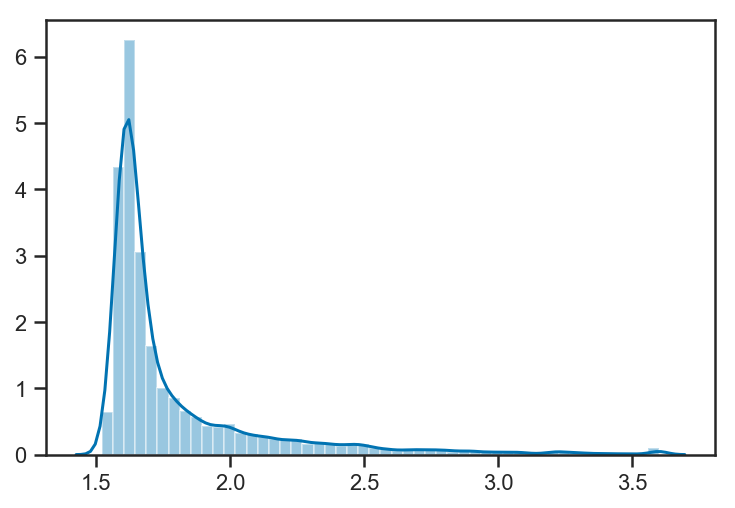

In [96]:
sns.distplot(log10(nsamp))

In [99]:
with h5py.File('observations.h5', 'a') as f:
    del f['posteriors']['nsamp']
    f['posteriors']['nsamp'] = nsamp